## Views data for a participant number

In [1]:
import tensorflow as tf
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from librosa.core import resample
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = '/home/seth/datasets/gut/src'

In [3]:
classes = ['anxiety', 'baseline', 'concentration', 'digestion', 'disgust', 'frustration']

In [4]:
p_num = 6

In [5]:
files = [os.path.join(data_path, 'p'+str(p_num), c+'_'+str(p_num)+'_'+'xy.wav') for c in classes]
for f in files: print(f)

/home/seth/datasets/gut/src/p6/anxiety_6_xy.wav
/home/seth/datasets/gut/src/p6/baseline_6_xy.wav
/home/seth/datasets/gut/src/p6/concentration_6_xy.wav
/home/seth/datasets/gut/src/p6/digestion_6_xy.wav
/home/seth/datasets/gut/src/p6/disgust_6_xy.wav
/home/seth/datasets/gut/src/p6/frustration_6_xy.wav


### Plot a little bit of the time series

Just trying to get an idea of what each class might look like

anxiety        : 30705217
baseline       : 28851043
concentration  : 28810523
digestion      : 86267332
disgust        : 43217533
frustration    : 28832009


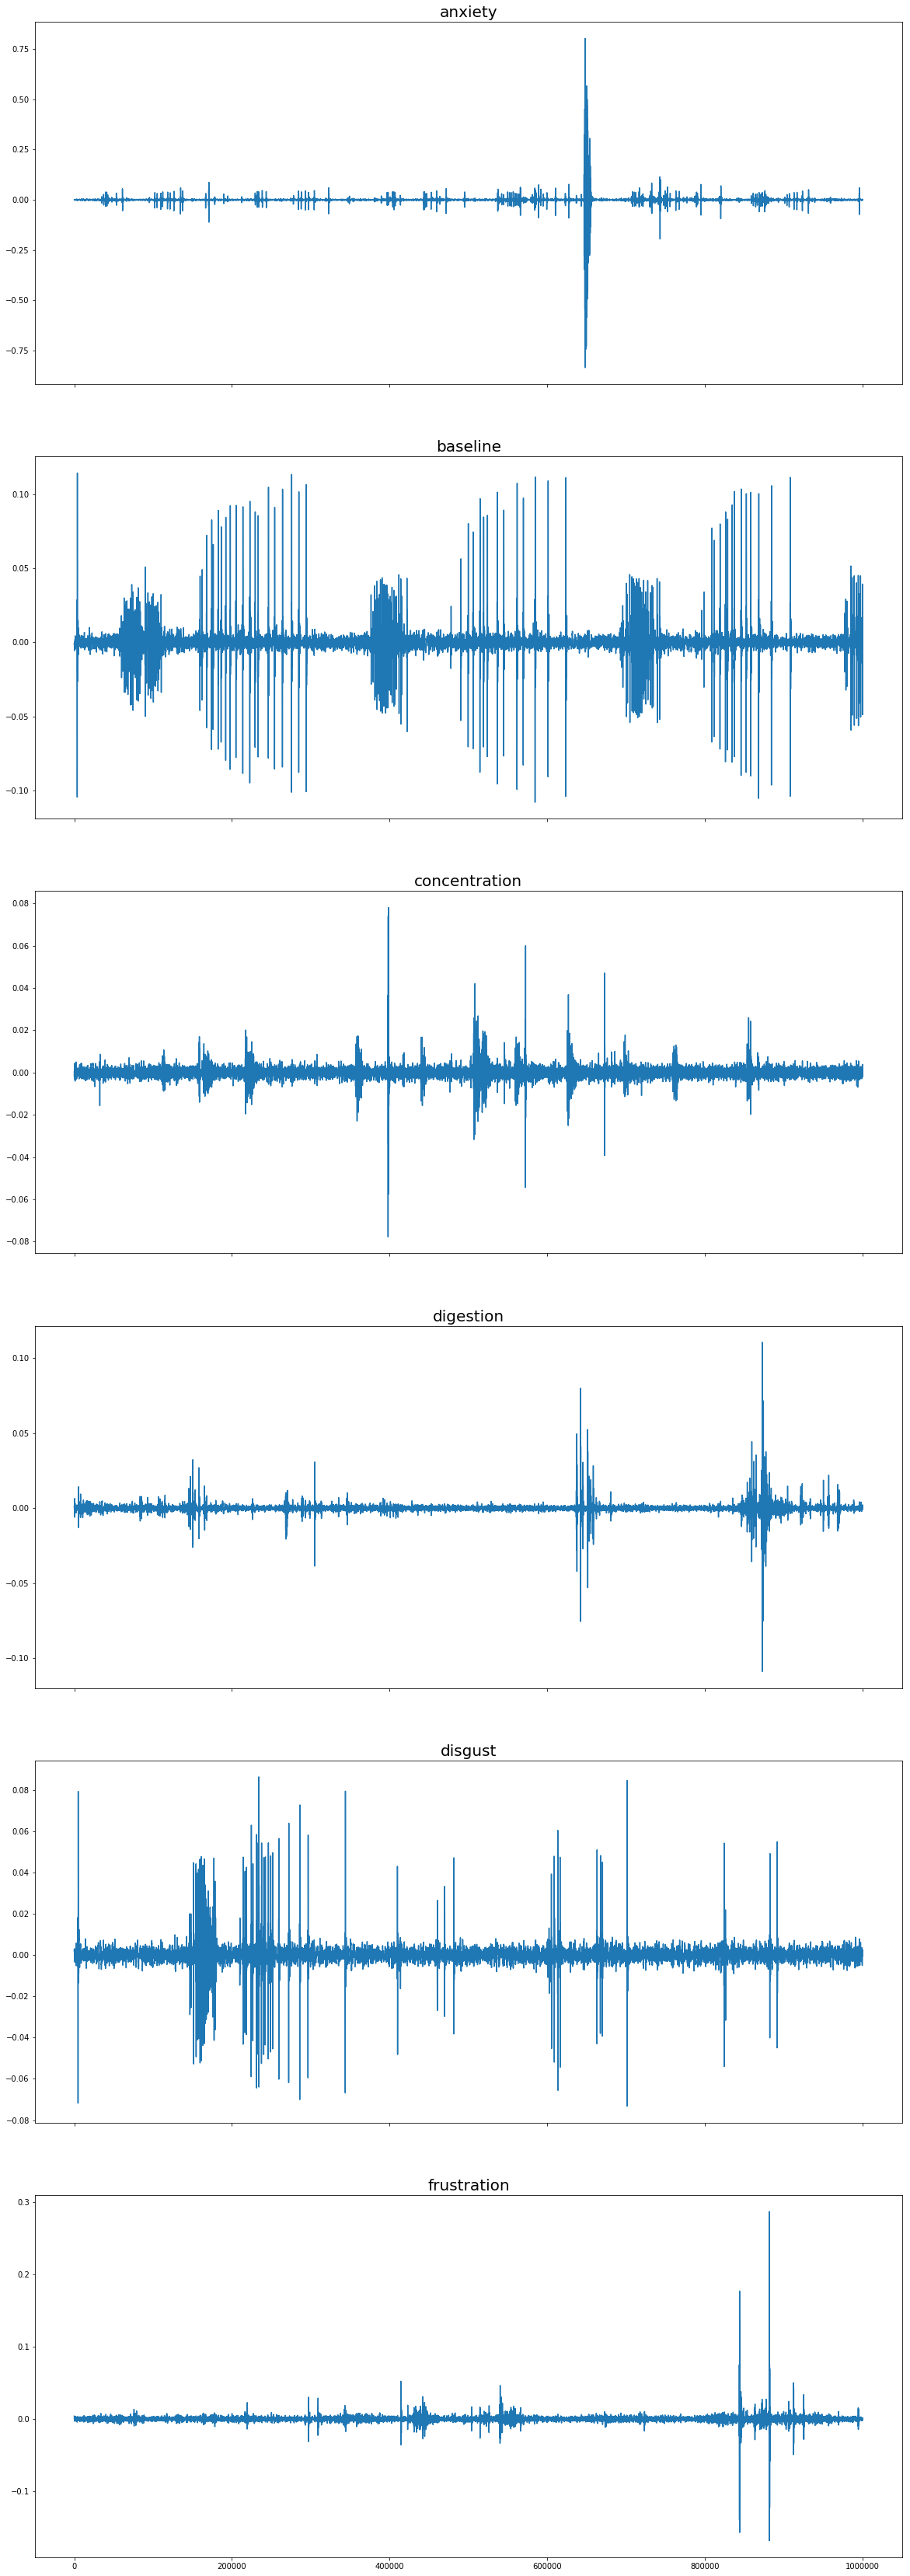

In [6]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=False, figsize=(20, 60))

for i in range(6):
    rate, signal = wavfile.read(files[i])
    print('{0:<15}: {1:}'.format(classes[i], signal.shape[0]))
    signal = signal[2000000:3000000,:]
    ax[i].plot(signal.sum(axis=1) / 2)
    ax[i].set_title(classes[i], size=20)

plt.show()

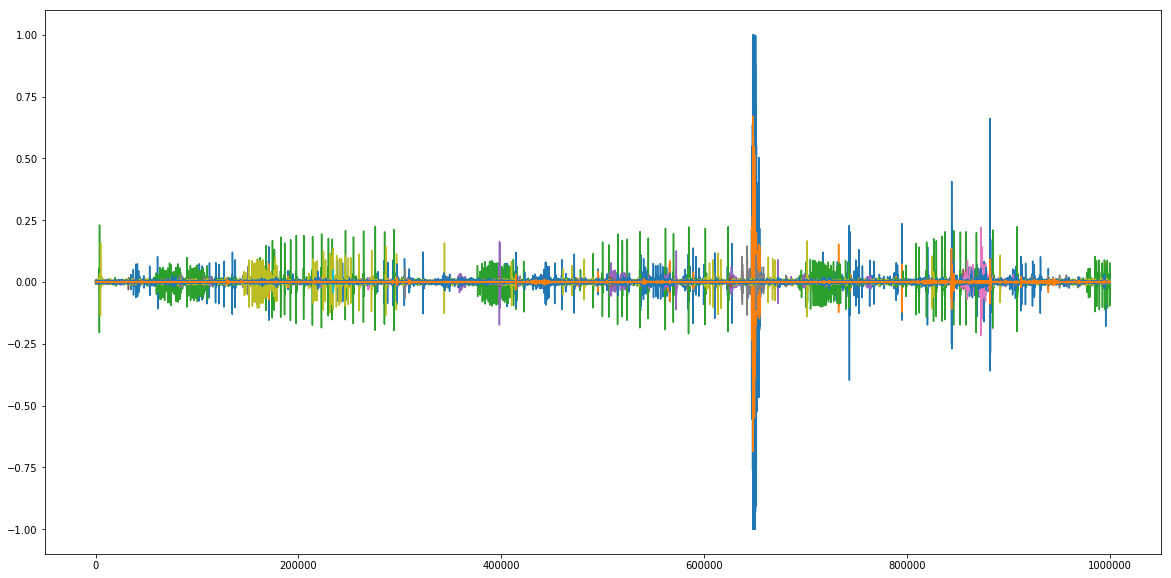

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(6):
    rate, signal = wavfile.read(files[i])
    signal = signal[2000000:3000000,:]
    ax.plot(signal)
plt.show()

In [8]:
def calc_fft(y, rate):
    
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [9]:
def calc_mfcc(spectrograms, n_bins):
    
    sample_rate = 8000.0
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = n_bins
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, 4000.0, 13
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    _mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :13]
    
    return _mfccs

### Downsample audio to 8k sampling rate and calculate FFT, STFT, MFCC of the above time series

In [10]:
# fs = 8000, n_fft = 1024, hop_length = 80 (10 ms), win_length = 200 (25 ms)
target_rate = 8000
frame_length = int(target_rate * 0.025)
frame_step = int(target_rate * 0.01)

ffts = []
stfts = []
mfccs = []

for i in tqdm(range(6)):

    # read wavfile and downsample
    rate, signal = wavfile.read(files[i])
    mono = signal.sum(axis=1) / 2
    mono = mono[2000000:3000000]
    down = resample(mono, rate, target_rate)

    # calc fft
    fft = calc_fft(down, target_rate)
    Y, freq = fft[0], fft[1]
    ffts.append((Y, freq))

    with tf.Session() as sess:
        
        # stft and mfcc
        tensor = tf.convert_to_tensor(down, dtype=tf.float32)
        Z = tf.signal.stft(signals=tensor, frame_length=frame_length, frame_step=frame_step, fft_length=1024)
        n_bins = Z.shape[-1].value
        Z = tf.abs(Z)
        mfcc = calc_mfcc(Z, n_bins=n_bins)
        Z = Z.eval(session=sess)
        mfcc = mfcc.eval(session=sess)
        stfts.append(Z)
        mfccs.append(mfcc)
        
    tf.reset_default_graph()

  0%|          | 0/6 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 6/6 [01:48<00:00, 18.03s/it]


### Plot FFTs

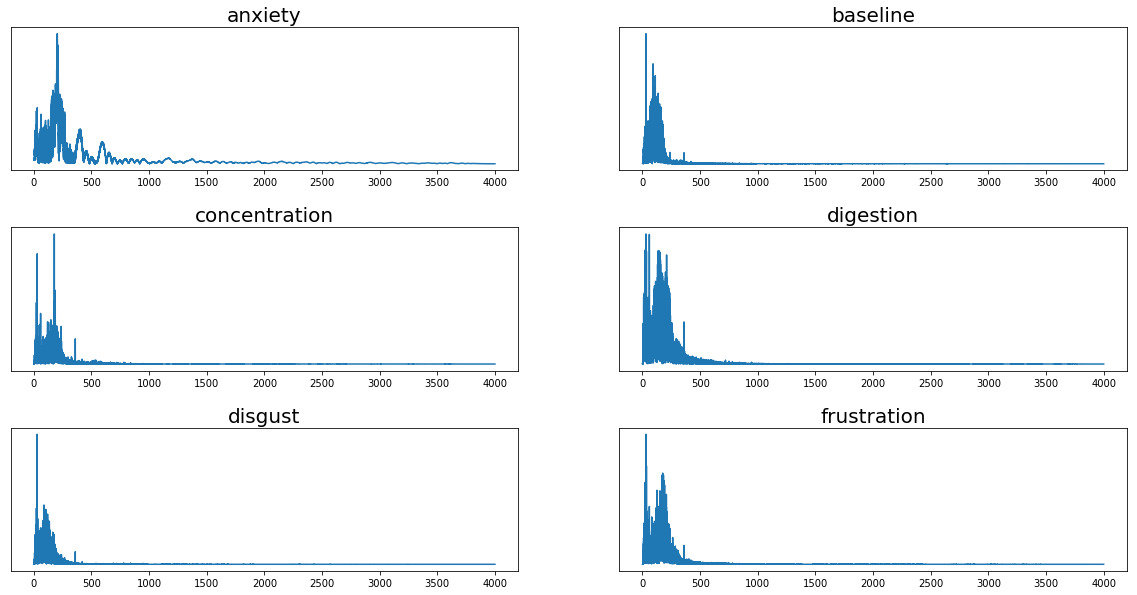

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4)

i = 0
for x in range(3):
    for y in range(2):
        Y, freq = ffts[i][0], ffts[i][1]
        ax[x,y].plot(freq, Y)
        ax[x,y].set_title(classes[i], size=20)
        ax[x,y].get_yaxis().set_visible(False)
        i+=1
plt.show()

We see most of the frequencies lie under 1k hertz

### Plot STFTs

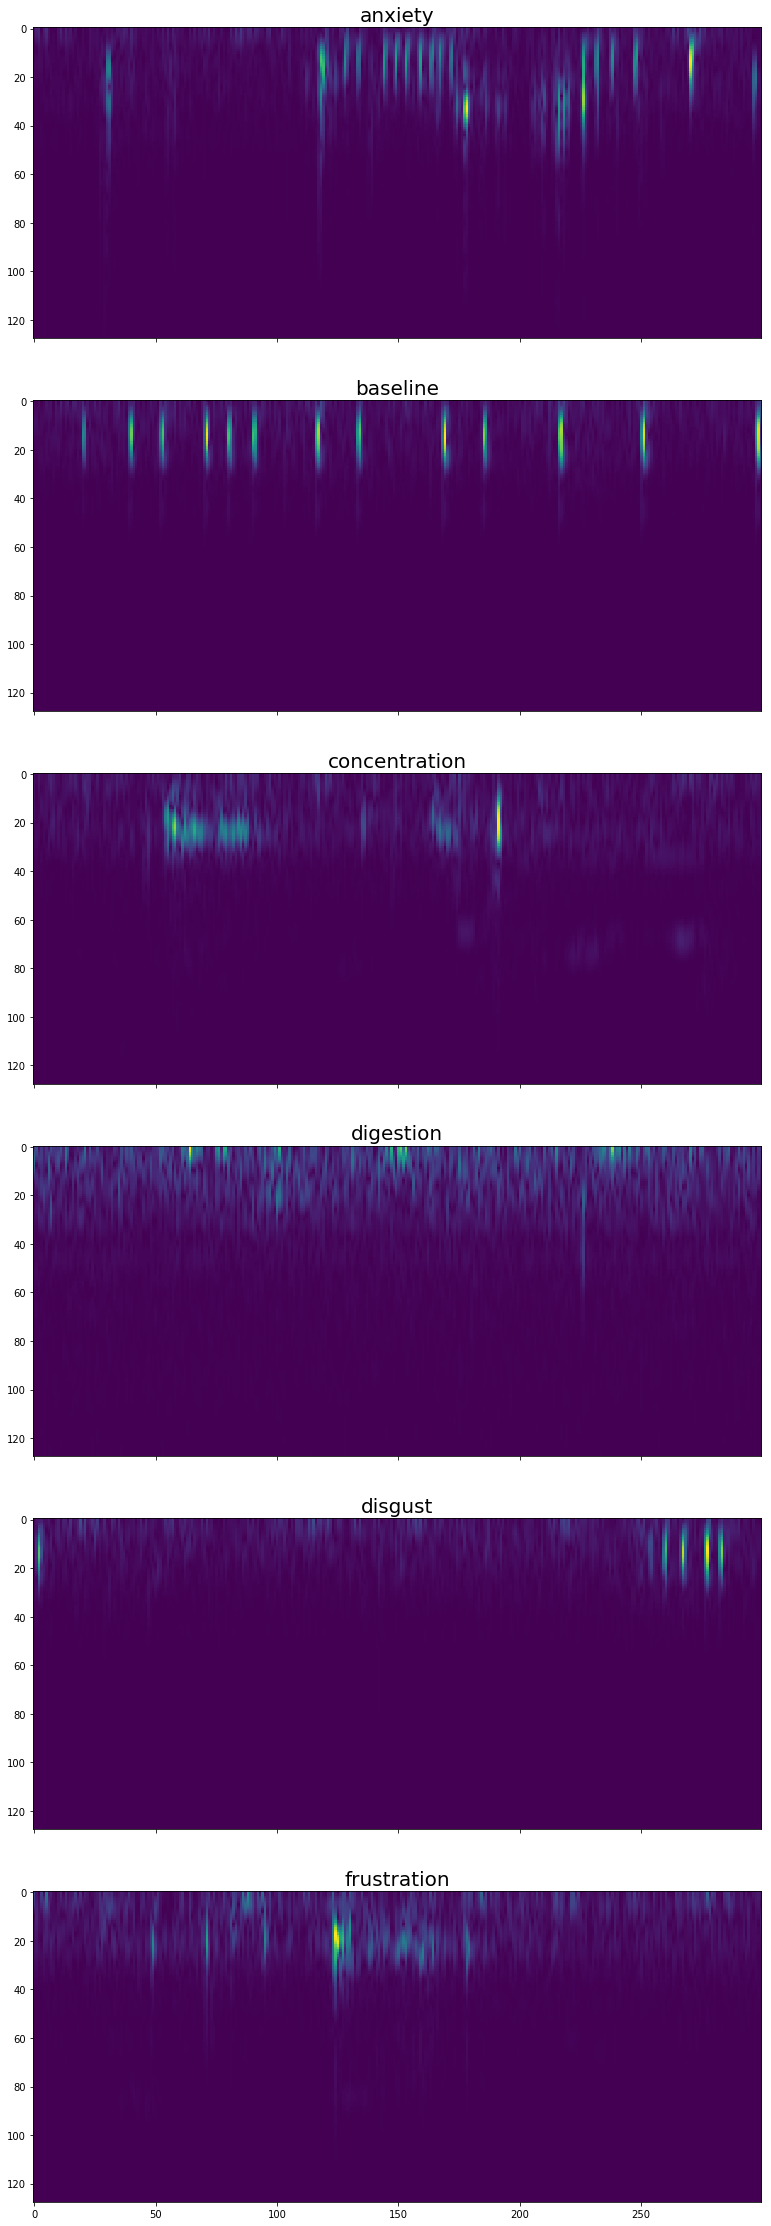

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=False, figsize=(20, 40))

for i in range(6):
    ax[i].imshow(stfts[i].T[:128,1000:1300])
    ax[i].set_title(classes[i], size=20)
plt.show()

### Plot MFCCs

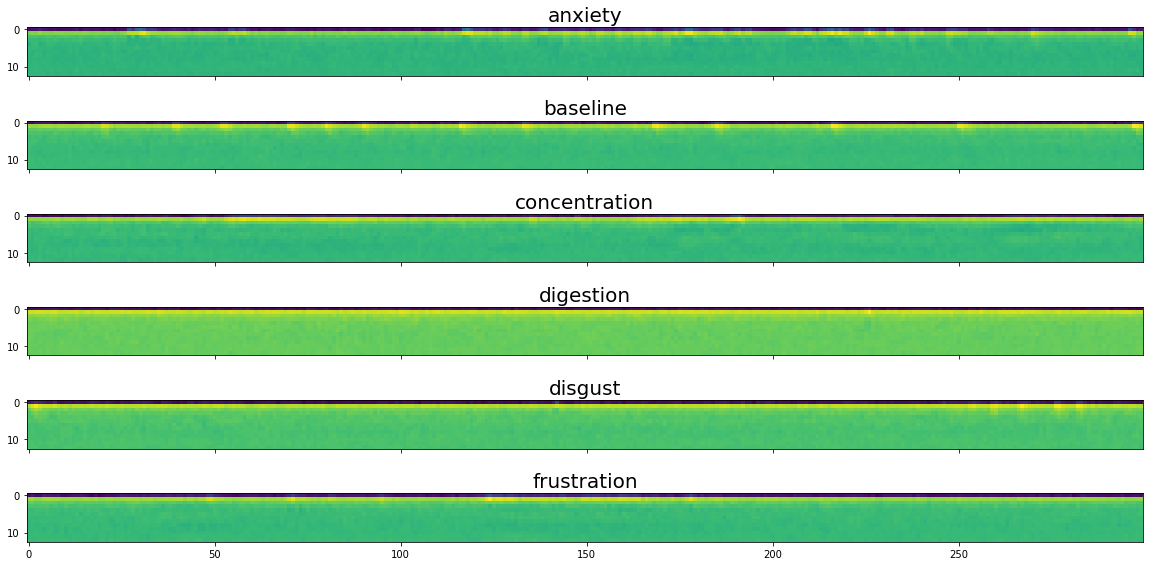

In [13]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=False, figsize=(20, 10))

for i in range(6):
    ax[i].imshow(mfccs[i].T[:,1000:1300])
    ax[i].set_title(classes[i], size=20)
plt.show()

This notebook shows the data pre processing steps that will need to be done before running through neural networks. It looks like most of the data lies below the 1k hertz frequency, so we can use 128 frequency bins from the stft. (4k nyquist frequency after down sampling to 8k) The MFCCs might be useful, but I have a feeling the STFTs will be better. It doesn't look like there is too much low frequnecy noise. There are a lot of low frequencies spread out, but these would likely be coming from the intestine. I need to make a script to downsample all audio to 8k and see how much disc space that would take. I also need to consider a noise threshold to remove deadspots, but that can be done next. I will also use a high pass filter at a low frequency to remove any noise the sensor is contributing.